In [1]:
import cv2
import requests
import numpy as np
from datetime import datetime, timedelta
import os
import glob

os.chdir('/home/itai/WD-opencv2') #set Working Directory

PATH_to_stream = 'http://192.168.11.115:8080/?action=streaming'
PATH_to_data_directory = '/home/itai/WD-opencv2'+'/data'
dir_path = os.path.dirname(os.path.realpath('__file__'))

Set the Working directory

In [2]:
%pwd
os.getcwd()

'/home/itai/WD-opencv2'

In [8]:
imgs_names_list =list(glob.glob(PATH_to_data_directory  + '/*'))

In [9]:
img = imgs_names_list[0]

In [10]:
img

'/home/itai/WD-opencv2/data/img2021-07-21 14:44:55.073720.jpg'

In [11]:
img = cv2.imread(img)

In [12]:
(h, w, c) = img.shape[:3]
# display the image width, height, and number of channels to our
# terminal
print("width: {} pixels".format(w))
print("height: {}  pixels".format(h))
print("channels: {}".format(c))

width: 1280 pixels
height: 720  pixels
channels: 3


In [13]:
#cv2.imshow("Image", img)
#cv2.waitKey(0)

In [16]:
from IPython.display import display
from PIL import Image
from matplotlib.pyplot import imshow

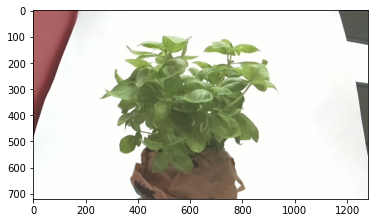

In [17]:
%matplotlib inline
pil_im = Image.open(imgs_names_list[0], 'r')
imshow(np.asarray(pil_im))

'/home/itai/WD-opencv2'